In [1]:
import pandas as pd
from scipy.spatial.distance import pdist
from unifrac import faith_pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from skbio.stats.ordination import pcoa
from skbio import TreeNode
from friendly_guacamole.datasets import DietInterventionStudy
from friendly_guacamole.transforms import Rarefaction, CLR, AsDense, UniFrac, \
    RarefactionBIOM, FaithPD
from q2_anomaly_detection.benchmark import Benchmark, ColumnValueSplitter, ExternalScorer
from q2_anomaly_detection.utils import as_dense, TrivialScorer
%matplotlib inline
from gemelli.rpca import rpca
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from skbio.diversity import alpha_diversity
from biom import load_table
from adtk.detector import (
    AutoregressionAD,
    InterQuartileRangeAD,
    ThresholdAD,
    GeneralizedESDTestAD,
    PersistAD,
)
from friendly_guacamole.datasets import Dataset, QiitaTable, QiitaMetadata, GreenGenes97Tree

In [2]:
RANDOM_SEED = 825
RAREFACTION_DEPTH = 1000

In [3]:
class RPCA(BaseEstimator):
    def __init__(self, n_components=2):
        self.n_components = n_components

    def fit(self, X, y=None):
        self.ordination, distances = rpca(X, n_components=self.n_components)
        self.embedding_ = self.ordination.samples
        return self
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.embedding_
    
    def transform(self, X):
        # TODO raise error
        pass

class AlphaDiversity(BaseEstimator, TransformerMixin):

    def __init__(self, metric):
        self.metric = metric

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return alpha_diversity(self.metric, X).values.reshape(-1, 1)

# TODO
# * extract diagonal
# * make sure biom table is sorted

class DiagonalExtraction(BaseEstimator, TransformerMixin):
    """
       s1 s2 s3 s4
    t1  0  1  2  3
    t2  4  5  6  7
    t3  8  9 10 11
    t4 12 13 14 15

    offset = -1
    start s1-t2 s2-t3 s3-t4
      pad     4     9    14

    offset = -2
    start1 start2 s1-t3 s2-t4
      pad     pad     8    13

    offset = 1
    t1-s2 t2-s3 t3-s4 end
        1     6    11 pad
    """

    def __init__(self, offset=0, pad_value=0):
        self.offset = offset
        self.pad_value = pad_value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        n_samples = len(X)
        offset = self.offset
        start = max(0, -offset)
        end = min(n_samples, n_samples - offset)
        extracted_values = np.diagonal(X, offset=offset)

        if self.pad_value == 'mean':
            pad_value = extracted_values.mean()
        elif self.pad_value == 'first':
            pad_value = extracted_values[0]
        elif self.pad_value == 'last':
            pad_value = extracted_values[-1]
        else:
            pad_value = self.pad_value
        diag = np.full(n_samples, pad_value, dtype=float)
        diag[start:end] = extracted_values
        return diag.reshape(-1, 1)

In [4]:
table = load_table("data/waste-water/genome_rep200.biom")
metadata_all = pd.read_csv("data/waste-water/13546_20210421-095533.txt", sep='\t')
metadata_in_table = metadata_all.loc[metadata_all.sample_name.isin(table.ids())]
metadata_in_table.shape

/Users/kcantrel/opt/anaconda3/envs/anomaly/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (15,16,43,45) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(218, 67)

In [5]:
def construct_category(metadata):
    pass


def subset_metadata(metadata_all, table):
    metadata = metadata_all.query('sample_type == "waste water"')
    return metadata
metadata_in_table = subset_metadata(metadata_in_table, table)

In [6]:
# metadata = subset_metadata(metadata_in_table, table)

# metadata = metadata.set_index('sample_name')

In [7]:
# table.filter(metadata.index, axis='sample', inplace=True)
# np.random.seed(RANDOM_SEED)
# subtable = table.subsample(RAREFACTION_DEPTH)
# submetadata = metadata.loc[metadata.index.isin(subtable.ids('sample'))]

In [8]:
from adtk.detector import (
    AutoregressionAD,
    InterQuartileRangeAD,
    ThresholdAD,
    GeneralizedESDTestAD,
    PersistAD,
)


In [9]:
def format_params(d):
    strings = []
    for p, v in d.items():
        strings.append(f'{p}-{v}')
    return '--'.join(strings)

/Users/kcantrel/opt/anaconda3/envs/anomaly/lib/python3.8/site-packages/gemelli/preprocessing.py:155: RuntimeWarning: divide by zero encountered in log
  M_log = np.log(M_log.squeeze())
No handles with labels found to put in legend.
/Users/kcantrel/opt/anaconda3/envs/anomaly/lib/python3.8/site-packages/gemelli/preprocessing.py:155: RuntimeWarning: divide by zero encountered in log
  M_log = np.log(M_log.squeeze())
No handles with labels found to put in legend.
/Users/kcantrel/opt/anaconda3/envs/anomaly/lib/python3.8/site-packages/gemelli/preprocessing.py:155: RuntimeWarning: divide by zero encountered in log
  M_log = np.log(M_log.squeeze())
No handles with labels found to put in legend.
/Users/kcantrel/opt/anaconda3/envs/anomaly/lib/python3.8/site-packages/gemelli/preprocessing.py:155: RuntimeWarning: divide by zero encountered in log
  M_log = np.log(M_log.squeeze())
No handles with labels found to put in legend.
/Users/kcantrel/opt/anaconda3/envs/anomaly/lib/python3.8/site-packages/g

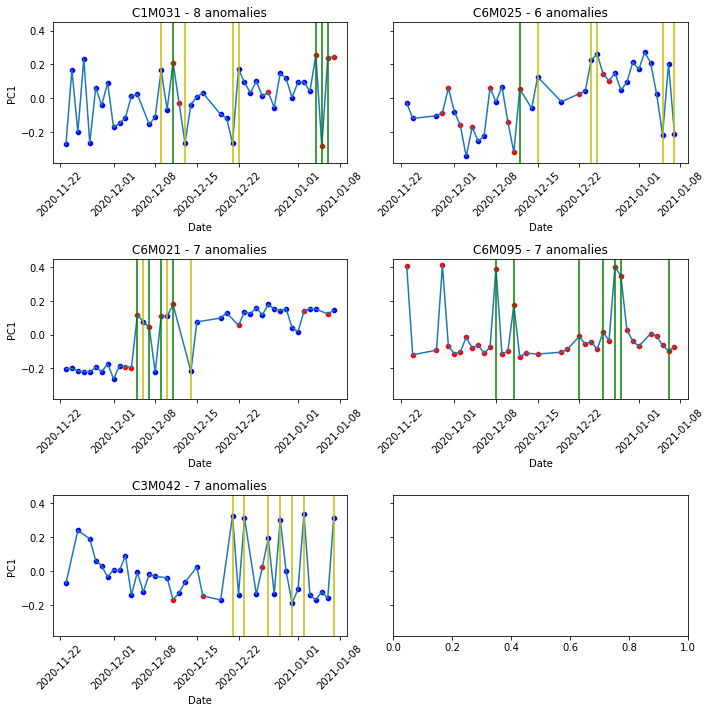

In [10]:
subtable = table
submetadata = metadata_in_table.set_index("sample_name")
submetadata["time"] = pd.to_datetime(submetadata.collection_timestamp)
fig, axs = plt.subplots(3, 2,
                        figsize=(10, 10),
#                         sharex=True,
                        sharey=True,
                        )
plot_name = 'manhole_id'
for i, sample_id in enumerate(submetadata[plot_name].unique()):
    indivduals_metadata = submetadata.loc[submetadata[plot_name] == sample_id]
    indivduals_ids = indivduals_metadata.index
    individual_table = subtable.filter(indivduals_ids, inplace=False)
    indivduals_metadata = indivduals_metadata.loc[individual_table.ids()]
    no_index = indivduals_metadata.reset_index()
    pca = Pipeline([
        ("RPCA", RPCA()),
        ("select", ColumnTransformer(
            [("PC", "passthrough", ["PC1", "PC2"])]
        ))
    ])
    P = pca.fit_transform(individual_table)

    # compute AD
    # ad = PersistAD(window=5, c=0.8)
    model_name = 'persist-ad'
    params = {
        'window': 10,
        'c': 0.1,
    }
    ad = PersistAD(**params)
    ad_series = pd.Series(
        P[:, 0],
        index=submetadata.loc[individual_table.ids()]["time"],
    )
    ad_series = ad_series.sort_index()
    anomalies = ad.fit_detect(ad_series)
    dropna_anomalies = anomalies.dropna()
    anomalies_x = dropna_anomalies.loc[dropna_anomalies.astype(bool).to_numpy()]

    # plot AD
    h_pos = i // 2
    v_pos = i % 2
    
    g = sns.lineplot(
        x=indivduals_metadata.loc[individual_table.ids()]["time"],
        y=P[:, 0],
        ax=axs[h_pos, v_pos],
#         marker='o',
    )
    g.set_title(sample_id + ' - ' + str(len(anomalies_x)) + ' anomalies')
    g.legend().remove()
    
    
    
    covid_times = indivduals_metadata.loc[indivduals_metadata['sars_cov_2_status'] == 'positive', 'time']
    anomaly_times = anomalies_x.index
    both_time = set(covid_times) & set(anomaly_times)    
    covid_only_times = set(covid_times) - both_time
    anomaly_only_times = set(anomaly_times) - set(both_time)
    for anom in anomaly_only_times:
        g.axvline(anom, 0, 1,
                  color='y',
                  linewidth=1.5,
#                   alpha=0.5,
                  )
#     for anom in covid_only_times:
#         g.axvline(anom, 0, 1,
#                   color='r',
#                   linewidth=1,
#                   alpha=0.5,
#                   )
        
    for anom in both_time:
        g.axvline(anom, 0, 1,
                  color='g',
                  linewidth=1.5,
#                   alpha=0.5,
                  )
    g.set_ylabel('PC1')
    g.set_xlabel('Date')

    for tick in g.get_xticklabels():
        tick.set_rotation(45)
    sns.scatterplot(
        x=indivduals_metadata.loc[
            (indivduals_metadata['sars_cov_2_status'] == 'positive')]['time'],
        y=P[
            no_index.loc[(no_index.reset_index()['sars_cov_2_status'] == 'positive')].index.values,
            0],
        color="r",
        ax=axs[h_pos, v_pos],
    )
    sns.scatterplot(
        x=indivduals_metadata.loc[
            ~(indivduals_metadata['sars_cov_2_status'] == 'positive')]['time'],
        y=P[
            no_index.loc[~(no_index.reset_index()['sars_cov_2_status'] == 'positive')].index.values,
            0],
        color="b",
        ax=axs[h_pos, v_pos],
    )

# plt.savefig(f'results/diet-intervention-time-series--{model_name}'
#             f'--{format_params(params)}.png')
# plt.savefig(f'results/diet-intervention-time-series.png')

plt.tight_layout()

In [11]:
submetadata.collection_timestamp.unique()

array(['2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
       '2020-12-05', '2020-12-07', '2020-12-08', '2020-12-09',
       '2020-12-10', '2020-12-11', '2020-12-12', '2020-12-13',
       '2020-12-14', '2020-12-15', '2020-12-16', '2020-12-19',
       '2020-12-20', '2020-12-21', '2020-12-22', '2020-12-23',
       '2020-12-24', '2020-12-25', '2020-12-26', '2020-12-27',
       '2020-12-28', '2020-12-29', '2020-12-30', '2020-12-31',
       '2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
       '2021-01-05', '2021-01-06', '2021-01-07', '2020-11-23',
       '2020-11-24', '2020-11-25', '2020-11-26', '2020-11-27',
       '2020-11-28', '2020-11-29', '2020-11-30', '2020-12-06'],
      dtype=object)